<h1><strong>Wine Description Sentiment Analysis using LSTM</strong></h1>
<p>Samantha Fields-Samotowka</p>
<p>CISB-62</p>
<p>CRN 21058</p>
<p>December 10, 2023</p>

<h2>Explanation of Project</h2>
<p>I will be running sentiment analysis on the descriptions of wines from reviewers, then taking in new reviews and determining the sentiment of them.</p>

<h2>Techniques Employed</h2>
<ul>
    <li>LSTM</li>
    <li>Regular Expressions</li>
    <li>Tokenization</li>
    <li>Text Processing</li>
    <li>Dataset Processing and Manipulation</li>
</ul>

<p>The dataset is pulled from <a href="https://www.kaggle.com/datasets/zynicide/wine-reviews/">this link</a> from Kaggle. It was created and prepared by the user Zackthoutt. I will be using the V2 CSV file, located in the data subfolder.</p>

<p>For the new reviews, I read through the existing descriptions and took my time to craft three, shown below: a very positive, a very negative, and a neutral review.</p>
<p>This wine is an absolute gem! From the moment I opened the bottle, the rich aroma of ripe berries and subtle hints of oak filled the air. The deep, velvety texture and complex flavour profile delighted my palate with notes of black cherry, vanilla, and a touch of spice. The tannins were smooth, providing a luxurious mouthfeel that lingered pleasantly. This wine is a true masterpiece, perfect for special occasions or simply indulging in a moment of pure bliss.</p>
<p>I regretfully purchased this wine based on its seemingly positive reputation, and it was a complete disappointment. The first sip assaulted my senses with an overpowering acidity that overshadowed any potential flavours. The taste was harsh and astringent, leaving a bitter aftertaste that lingered unpleasantly. The alleged notes of fruit were practically nonexistent, drowned out by an overwhelming bitterness. I cannot fathom how anyone could enjoy this wine, and I certainly won't be making the mistake of buying it again.</p>
<p>This wine falls somewhere in the middle for me. It has a decent balance of flavours without standing out in any particular way. The aroma upon opening was pleasant, with subtle notes of red berries and a hint of oak. The taste was moderate, with a mix of fruit flavors and a touch of earthiness. The acidity was present but not overly pronounced. The finish was smooth, although it didn't leave a lasting impression. Overall, it's an okay wine, suitable for casual occasions, but it lacks the complexity and depth that would make it truly memorable.</p>

<h3>Import Statements</h3>

In [1]:
#General Libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

#NLTK Text Processing Libraries
import nltk
from nltk.corpus import stopwords
import re
import string
from string import punctuation

#Model Building Libraries
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
#For some reason, this would not work. I needed to do the full function call all the way back to Tensorflow
#from keras.preprocessing import sequence 

#Model Saving and Loading Libraries
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

#Miscellaneous Library
import warnings
warnings.filterwarnings("ignore")

<h3>Dependencies and Constants</h3>

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Samantha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
english_stops = set(stopwords.words("english"))

In [4]:
checkpoint = ModelCheckpoint("models/LSTM.h5", monitor="accuracy", save_best_only=True, verbose=1)

<h3>Required Functions</h3>

In [5]:
#This function cleans a string of punctuation and stop words for NLP processing
def get_text_processing(text):
    stopword = stopwords.words("english")
    no_punc = [char for char in text if char not in string.punctuation]
    no_punc = "".join(no_punc)
    
    return " ".join([word for word in no_punc.split() if word.lower() not in stopword])

In [6]:
#This function cleans a sample of punctuation and stop words for Deep Learning processing
#It also assigns the samples to Training and Testing variables
def load_dataset(data, X, y):
    df = data
    
    x_data = df[X]
    y_data = df[y]
    
    x_data = x_data.replace({"<.*?>": ""}, regex=True)
    x_data = x_data.replace({"[^A-Za-z]": " "}, regex=True)
    x_data = x_data.apply(lambda X: [w for w in X.split() if w not in english_stops])
    x_data = x_data.apply(lambda X: [w.lower() for w in X])
    
    y_data = y_data.replace("positive", 1)
    y_data = y_data.replace("negative", 0)
    
    return x_data, y_data

In [7]:
#This function gets the maximum length of the descriptions, for later padding and processing
def get_max_length():
    desc_length = []
    for desc in X_train:
        desc_length.append(len(desc))
    
    return int(np.ceil(np.mean(desc_length)))

In [8]:
#This function shows a given model's metrics
def show_metric(model, metric_1, metric_2, title):
    plt.figure(figsize=(12,6))
    plt.plot(model.history.history[metric_1], label=metric_1)
    plt.plot(model.history.history[metric_2], label=metric_2)
    plt.legend()
    plt.title(title)
    plt.show()

In [9]:
#This function takes the description and cleans it of punctuation and stop words for running it through the model
def filter_input(description):
    regex = re.compile(r"[^a-zA-Z\s]")
    description = regex.sub("", description)
    print("Cleaned: ", description)
    
    words = description.split(" ")
    filtered = [w for w in words if w not in english_stops]
    filtered = " ".join(filtered)
    filtered = [filtered.lower()]
    print("Filtered: ", filtered)
    
    return filtered

In [10]:
#This function takes in the model's output and determines if the review was positive or negative
def display_results(result):
    if result < 0.5:
        print("The description was negative.")
    elif result >= 0.5:
        print("The description was positive.")

In [11]:
#This function takes in a review and predicts the sentiment
def predict_sentiment():
    description = str(input("Wine Description: "))
    print()
    
    filtered = filter_input(description)
    print()
    
    tokenize_words = token.texts_to_sequences(filtered)
    tokenize_words = tf.keras.preprocessing.sequence.pad_sequences(tokenize_words, maxlen=max_length, padding="post", truncating="post")
    print(tokenize_words)
    print()

    result = loaded_model.predict(tokenize_words)
    print(result)
    print()

    display_results(result)

<h1>Exploratory Data Analysis</h1>

<h3>Load data</h3>

In [12]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")

<h3>Visualization</h3>

In [13]:
wine_reviews.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [14]:
wine_reviews.tail()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
129966,129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss
129970,129970,France,"Big, rich and off-dry, this is powered by inte...",Lieu-dit Harth Cuvée Caroline,90,21.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...,Gewürztraminer,Domaine Schoffit


<Axes: xlabel='points', ylabel='count'>

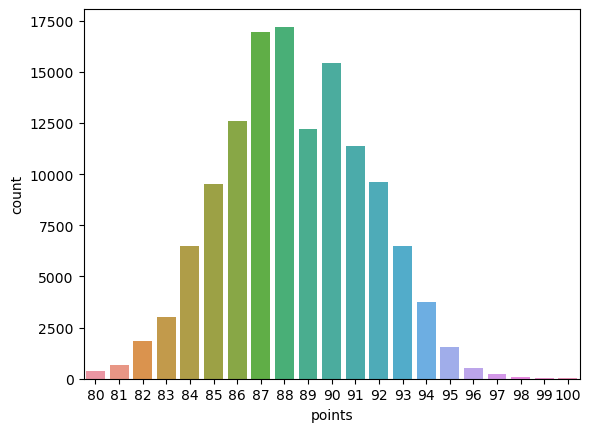

In [15]:
sn.countplot(wine_reviews, x="points")

<h3>Data Transformation</h3>

In [16]:
#Dropping unnecessary columns
wine_clean = wine_reviews.drop(columns=["Unnamed: 0", "taster_twitter_handle", "title", "winery"])
wine_clean.dropna(inplace=True)

In [17]:
wine_clean.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,variety
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Pinot Noir
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,Cabernet Sauvignon
23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,Merlot
25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,Pinot Noir
35,US,As with many of the Erath 2010 vineyard design...,Hyland,86,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,Pinot Noir


In [18]:
#Creating a new column for the rating, based on the points assigned by the reviewer
wine_clean["polarity_rating"] = wine_clean["points"].apply(lambda x: "positive" if x > 85 else "negative")

<Axes: xlabel='points', ylabel='count'>

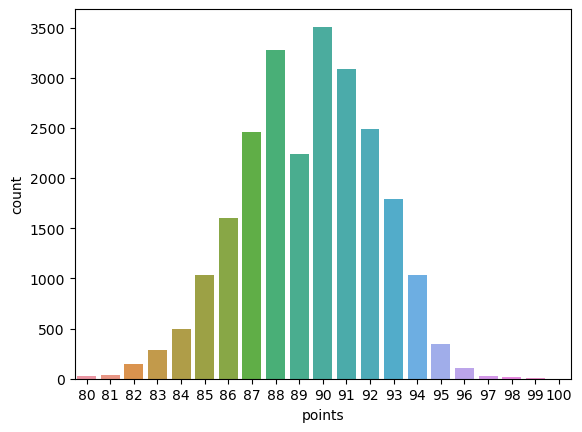

In [19]:
sn.countplot(wine_clean, x="points")

<Axes: xlabel='polarity_rating', ylabel='count'>

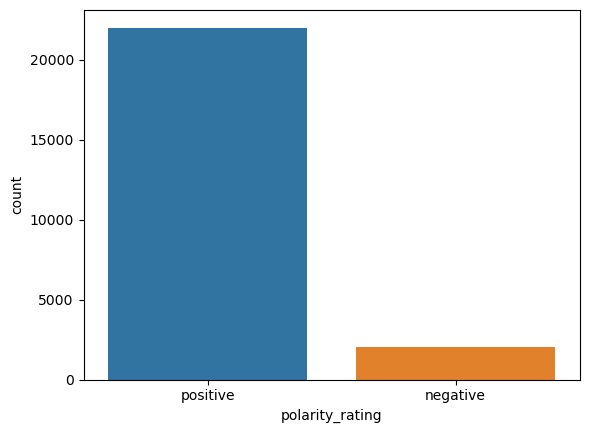

In [20]:
sn.countplot(wine_clean, x="polarity_rating")

In [21]:
#Creating the sample dataset for analysis
data_positive = wine_clean[wine_clean["polarity_rating"] == "positive"][0:8000]
data_negative = wine_clean[wine_clean["polarity_rating"] == "negative"]

In [22]:
data_negative_over = data_negative.sample(8000, replace=True)
data = pd.concat([data_positive, data_negative_over], axis=0)

In [23]:
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,variety,polarity_rating
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Pinot Noir,positive
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,Cabernet Sauvignon,positive
23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,Merlot,positive
25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,Pinot Noir,positive
35,US,As with many of the Erath 2010 vineyard design...,Hyland,86,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,Pinot Noir,positive


In [24]:
#Processing the descriptions for punctuation and stop words
data["desc"] = data["description"].apply(get_text_processing)

In [25]:
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,variety,polarity_rating,desc
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Pinot Noir,positive,Much like regular bottling 2012 comes across r...
10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,Cabernet Sauvignon,positive,Soft supple plum envelopes oaky structure Cabe...
23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,Merlot,positive,wine Geneseo district offers aromas sour plums...
25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,Pinot Noir,positive,Oak earth intermingle around robust aromas wet...
35,US,As with many of the Erath 2010 vineyard design...,Hyland,86,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,Pinot Noir,positive,many Erath 2010 vineyard designates strongly h...


In [26]:
#Creating a table of just the processed descriptions and rating
data_desc_rating = data[["desc", "polarity_rating"]]

In [27]:
data_desc_rating.head()

,desc,polarity_rating
4,Much like regular bottling 2012 comes across r...,positive
10,Soft supple plum envelopes oaky structure Cabe...,positive
23,wine Geneseo district offers aromas sour plums...,positive
25,Oak earth intermingle around robust aromas wet...,positive
35,many Erath 2010 vineyard designates strongly h...,positive


In [28]:
#Assigning the new table to a dataset
x_data, y_data = load_dataset(data_desc_rating, "desc", "polarity_rating")
print("Description")
print(x_data, "\n")
print("Sentiment")
print(y_data)

Description
4         [much, like, regular, bottling, comes, across,...
10        [soft, supple, plum, envelopes, oaky, structur...
23        [wine, geneseo, district, offers, aromas, sour...
25        [oak, earth, intermingle, around, robust, arom...
35        [many, erath, vineyard, designates, strongly, ...
                                ...                        
70743     [muscat, gummy, herb, aromas, followed, dry, t...
120915    [barrelfermented, pungent, whiff, glue, simple...
59041     [barrel, aromas, vanilla, coconut, far, front,...
29734     [principally, tempranillo, blended, red, shows...
62490     [lodigrown, blend, chardonnay, sauvignon, blan...
Name: desc, Length: 16000, dtype: object 

Sentiment
4         1
10        1
23        1
25        1
35        1
         ..
70743     0
120915    0
59041     0
29734     0
62490     0
Name: polarity_rating, Length: 16000, dtype: int64


In [29]:
#Splitting the dataset for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20)

In [30]:
#Finding the maximum length of the descriptions
max_length = get_max_length()
print(max_length)

24


In [31]:
#Instantiating the Keras Tokenizer
token = Tokenizer(lower=False)

#Fitting the Training subset to the tokenizer
token.fit_on_texts(X_train)

X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length, padding="post", truncating="post")
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length, padding="post", truncating="post")
#The pad_sequences function call here only worked when I used the full length sequence to call it. I have no idea why.

total_words = len(token.word_index) + 1

In [32]:
print(X_train)
print(X_test)
print(max_length)

[[  26   13   63 ... 6024   38    0]
 [ 445   40  373 ...  796   43   13]
 [ 224  240   43 ...  328    6    0]
 ...
 [  76  737  508 ... 1401  102  344]
 [  17   88   66 ...    0    0    0]
 [  26 3587   35 ...    0    0    0]]
[[ 520 2858 1977 ...    1 1273 4474]
 [3701   35  214 ...    0    0    0]
 [ 119  236   11 ...    0    0    0]
 ...
 [ 129  313    3 ...  401  935  793]
 [1251   94   77 ...   54  176    3]
 [1809    1  302 ...   58   56  584]]
24


<h1>Model Training and Sentiment Analysis</h1>

In [33]:
embed_dim = 32
lstm_out = 64

In [34]:
#Instantiating the Sequential model
model = Sequential()

#Input Layer and LSTM Layer
model.add(Embedding(total_words, embed_dim, input_length=max_length))
model.add(LSTM(lstm_out))

#Output Layer
model.add(Dense(1, activation="sigmoid"))

In [35]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 32)            377152    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 402,049
Trainable params: 402,049
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/10
 99/100 [============================>.] - ETA: 0s - loss: 0.4507 - accuracy: 0.7706
Epoch 1: accuracy improved from -inf to 0.77180, saving model to models\LSTM.h5
100/100 [==============================] - 10s 53ms/step - loss: 0.4488 - accuracy: 0.7718 - val_loss: 0.2767 - val_accuracy: 0.8878
Epoch 2/10
 99/100 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9361
Epoch 2: accuracy improved from 0.77180 to 0.93625, saving model to models\LSTM.h5
100/100 [==============================] - 4s 44ms/step - loss: 0.1800 - accuracy: 0.9362 - val_loss: 0.2021 - val_accuracy: 0.9247
Epoch 3/10
 99/100 [============================>.] - ETA: 0s - loss: 0.0954 - accuracy: 0.9697
Epoch 3: accuracy improved from 0.93625 to 0.96977, saving model to models\LSTM.h5
100/100 [==============================] - 3s 34ms/step - loss: 0.0955 - accuracy: 0.9698 - val_loss: 0.1880 - val_accuracy: 0.9391
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss:

<h1>Testing the Model</h1>

In [38]:
#Loading the trained model
loaded_model = load_model("models/LSTM.h5")

<p>The following five cells are to show each component of the sentiment analysis.</p>

In [39]:
description = str(input("Wine Description: "))

Wine Description: This wine is an absolute gem! From the moment I opened the bottle, the rich aroma of ripe berries and subtle hints of oak filled the air. The deep, velvety texture and complex flavor profile delighted my palate with notes of black cherry, vanilla, and a touch of spice. The tannins were smooth, providing a luxurious mouthfeel that lingered pleasantly. This wine is a true masterpiece, perfect for special occasions or simply indulging in a moment of pure bliss.


In [40]:
filtered = filter_input(description)

Cleaned:  This wine is an absolute gem From the moment I opened the bottle the rich aroma of ripe berries and subtle hints of oak filled the air The deep velvety texture and complex flavor profile delighted my palate with notes of black cherry vanilla and a touch of spice The tannins were smooth providing a luxurious mouthfeel that lingered pleasantly This wine is a true masterpiece perfect for special occasions or simply indulging in a moment of pure bliss
Filtered:  ['this wine absolute gem from moment i opened bottle rich aroma ripe berries subtle hints oak filled air the deep velvety texture complex flavor profile delighted palate notes black cherry vanilla touch spice the tannins smooth providing luxurious mouthfeel lingered pleasantly this wine true masterpiece perfect special occasions simply indulging moment pure bliss']


In [41]:
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = tf.keras.preprocessing.sequence.pad_sequences(tokenize_words, maxlen=max_length, padding="post", truncating="post")
print(tokenize_words)

[[    1 11176  5046  1609  1640   184    43   160    18   288   203    92
     14  1870   998  3789   206   376    27   154    36   479     4    11]]


In [42]:
result = loaded_model.predict(tokenize_words)
print(result)

1/1 [==============================] - 1s 1s/step
[[0.9375412]]


In [43]:
display_results(result)

The description was positive.


<p>The following function calls use exactly the same code as above, just packaged neater and cleaner.</p>

In [44]:
predict_sentiment()

Wine Description: I regretfully purchased this wine based on its seemingly positive reputation, and it was a complete disappointment. The first sip assaulted my senses with an overpowering acidity that overshadowed any potential flavors. The taste was harsh and astringent, leaving a bitter aftertaste that lingered unpleasantly. The alleged notes of fruit were practically nonexistent, drowned out by an overwhelming bitterness. I cannot fathom how anyone could enjoy this wine, and I certainly won't be making the mistake of buying it again.

Cleaned:  I regretfully purchased this wine based on its seemingly positive reputation and it was a complete disappointment The first sip assaulted my senses with an overpowering acidity that overshadowed any potential flavors The taste was harsh and astringent leaving a bitter aftertaste that lingered unpleasantly The alleged notes of fruit were practically nonexistent drowned out by an overwhelming bitterness I cannot fathom how anyone could enjoy t

In [45]:
predict_sentiment()

Wine Description: This wine falls somewhere in the middle for me. It has a decent balance of flavors without standing out in any particular way. The aroma upon opening was pleasant, with subtle notes of red berries and a hint of oak. The taste was moderate, with a mix of fruit flavors and a touch of earthiness. The acidity was present but not overly pronounced. The finish was smooth, although it didn't leave a lasting impression. Overall, it's an okay wine, suitable for casual occasions, but it lacks the complexity and depth that would make it truly memorable.

Cleaned:  This wine falls somewhere in the middle for me It has a decent balance of flavors without standing out in any particular way The aroma upon opening was pleasant with subtle notes of red berries and a hint of oak The taste was moderate with a mix of fruit flavors and a touch of earthiness The acidity was present but not overly pronounced The finish was smooth although it didnt leave a lasting impression Overall its an o

<h1>Summary and Conclusion</h1>

<h3>Summary</h3>

<p>This model is built using a dataset of wine descriptions and reviews, which has be cleaned and processed, to predict the sentiment of the description/review. The user is able to include their own review of a wine, and the model will predict the sentiment of it.</p>
<p>As an interesting side note, the description/review needs to be fairly long, or the model will predict it is strongly negative, even if there are only positive words within it.</p>

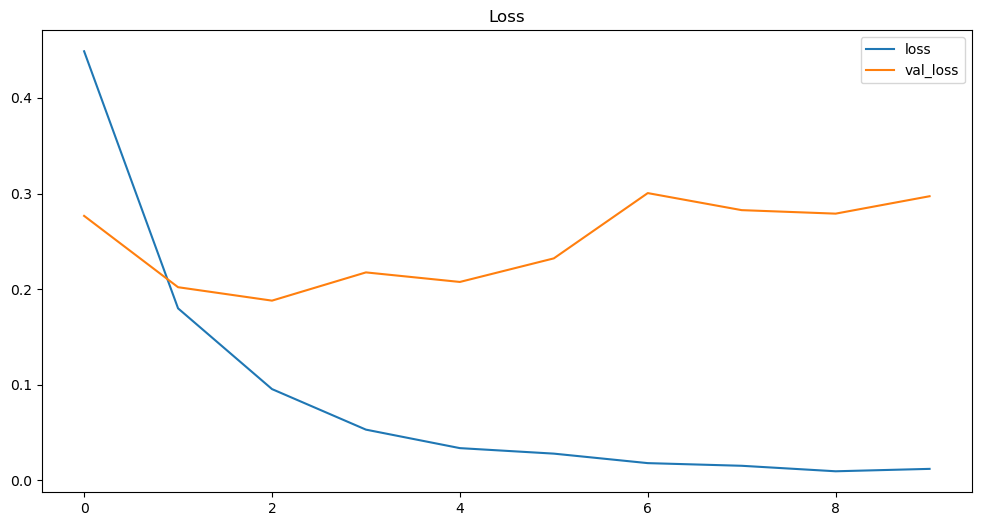

In [46]:
show_metric(model, "loss", "val_loss", "Loss")

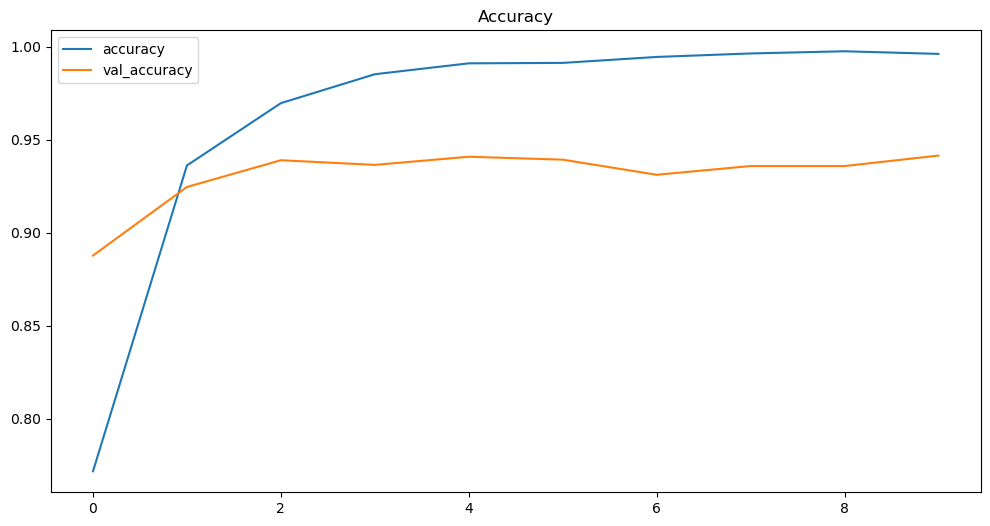

In [47]:
show_metric(model, "accuracy", "val_accuracy", "Accuracy")

<h3>Conclusion</h3>

<p>I ran this model with both 5 and 10 epochs, to see if there were any benefits to an increase in epochs (results from 10 epochs shown above). Unfortunately, it appears that the increase in epochs caused overfitting. The training accuracy jumped quite high, very fast, and continued to rise to 99.77%, but the testing accuracy stalled around 94%. To me, this is classic overfitting on the training data. In addition, the testing loss increased erratically, while the training loss rapidly and smoothly decreased to 0.0121, which again leads me to believe the model was overfit.</p>
<p>That being said, the model is still very good at what it does, and I would like to investigate adjustments in the future.</p>
<p>My original goal was to build a model that could identify the country that a wine is from, based on the description, but that is outside of my time scope. Some other ideas I have for this dataset are listed below.</p>
<ul>
	<li>Reviewer preferences</li>
	<li>Reviewer recommendations</li>
	<li>General recommendations</li>
	<li>Country, province/state, region, winery identification</li>
	<li>Wine designation or variety identification</li>
	<li>Price or age prediction</li>
</ul>
<p>Side Note: I have been getting more confident with my abilities to create my own functions. I have been working hard to generalize them, so that I could drop them into future code as needed, or even make my own generalized "utility" program that contains dozens of functions that I can import into projects.</p>